---
# Tutorial Task: Sentiment-Based Quant Strategy
---

In this tutorial, you will design and implement a **quantitative trading strategy** that makes trading decisions based on **news sentiment** for a selected group of 5 stocks.

## Objective

Each day, over a 1-week historical period:
- **Buy** (go long) the stock with the **most positive** news sentiment
- **Sell** (go short) the stock with the **most negative** news sentiment

You will:
1. Select your own **universe of 3 stocks** (e.g., AAPL, MSFT, GOOGL).
2. Use the provided News API to retrieve articles for each stock.
3. Calculate the **average sentiment** for each stock daily using tools like `TextBlob`.
4. Track your portfolio’s value over time by simulating simple returns (real or mock).
5. Plot your portfolio value and analyze strategy performance.

## Constraints

- The News API is limited to **100 requests per day**. Avoid excessive API calls while developing by storing data or limiting requests.
- You only trade **one long and one short position** per day.
- Keep it simple: assume equal capital allocation to long and short trades.

## Deliverables

- A working Jupyter notebook implementing the above strategy
- Comments and clear structure for readability
- A final plot showing portfolio value over the 1-week period


## Step 1:
Import relevant libraries

In [46]:
# Data analysis
import pandas as pd
import numpy as np
# API calls
import requests
# Sentiment analysis
from textblob import TextBlob
# Time arithmetic
from datetime import datetime, timedelta
# Plotting
import matplotlib.pyplot as plt
# Financial data
import yfinance as yf

## Step 2:
Configure API

In [ ]:
# Information to call API (variables capitalised to deonte constants)
API_KEY = 'YOUR_NEWS_API_KEY'  # Replace with your actual key
BASE_URL = 'https://newsapi.org/v2/everything'
STOCK_UNIVERSE = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
START_DATE = datetime(2025, 4, 1)
END_DATE = datetime(2025, 4, 7)

## Step 3:
Create a function to get news and calculate the sentiment

In [ ]:
# We use TextBlob() to calculate sentiment:

print(TextBlob("This stock is amazing!").sentiment.polarity)  # ➝ ~0.8 to 1.0 (positive)
print(TextBlob("This stock is okay.").sentiment.polarity)     # ➝ ~0.2 (slightly positive)
print(TextBlob("This stock is bad.").sentiment.polarity)      # ➝ ~-0.7 (negative)
print(TextBlob("This is a stock.").sentiment.polarity)    

0.7500000000000001
0.5
-0.6999999999999998
0.0


In [42]:
def get_sentiment(stock, date):
    from_date = date.strftime('%Y-%m-%d')
    to_date = (date + timedelta(days=1)).strftime('%Y-%m-%d')

    params = {
        'q': stock,
        'from': from_date,
        'to': to_date,
        'sortBy': 'relevancy',
        'apiKey': API_KEY,
        'language': 'en',
        'pageSize': 10
    }

    # Call API with the relevant stock and dates
    response = requests.get(BASE_URL, params=params)
    data = response.json() # response in a .json format
    
    print(data)

    sentiments = []
    for article in data.get('articles', []):
        title = article.get('title', '')
        description = article.get('description', '')
        
        if not title and not description:
            continue  # skip if both are missing
        
        text = f"{title} {description}"
        # Get sentiment of text
        sentiment = TextBlob(text).sentiment.polarity
        sentiments.append(sentiment)

    if sentiments:
        return np.mean(sentiments) # return the mean sentiment of the stock over the week
    return 0.0

In [43]:
get_sentiment('AAPL', START_DATE)

{'status': 'ok', 'totalResults': 41, 'articles': [{'source': {'id': None, 'name': '9to5Mac'}, 'author': 'Benjamin Mayo', 'title': 'Trump tariffs attack key parts of the Apple supply chain, Apple stock drops 7% in after-hours trading', 'description': 'The full extent of the U.S. government’s impeding tariffs were revealed by the Trump administration today in a press conference. The hefty tariffs threaten economic trade on a massive scale with implications on almost all big US companies, including Apple.\n\n\n…', 'url': 'https://9to5mac.com/2025/04/02/trump-tariffs-apple-stock-down/', 'urlToImage': 'https://i0.wp.com/9to5mac.com/wp-content/uploads/sites/6/2025/04/apple-stock-down-trump-tariffs.jpg?resize=1200%2C628&quality=82&strip=all&ssl=1', 'publishedAt': '2025-04-02T22:43:22Z', 'content': 'The full extent of the U.S. government’s impeding tariffs were revealed by the Trump administration today in a press conference. The hefty tariffs threaten economic trade on a massive scale with im

np.float64(0.13684415584415582)

## Step 4:
Simulate Trading

In [51]:
dates = pd.date_range(START_DATE, END_DATE)
strategy_returns = []
portfolio_value = 100000  # starting capital

for date in dates:
    print(f"Processing {date.strftime('%Y-%m-%d')}...")
    daily_sentiments = {}

    for stock in STOCK_UNIVERSE:
        try:
            sentiment = get_sentiment(stock, date)
            daily_sentiments[stock] = sentiment
        except Exception as e:
            print(f"Error retrieving news for {stock} on {date}: {e}")
            daily_sentiments[stock] = 0.0

    # pick long and short
    long_stock = max(daily_sentiments, key=daily_sentiments.get)
    short_stock = min(daily_sentiments, key=daily_sentiments.get)

    # Get market data from yfinance for both long and short
    next_day = date + pd.Timedelta(days=1)

    try:
        long_data = yf.download(long_stock, start=date.strftime('%Y-%m-%d'), end=next_day.strftime('%Y-%m-%d'), interval='1d')
        short_data = yf.download(short_stock, start=date.strftime('%Y-%m-%d'), end=next_day.strftime('%Y-%m-%d'), interval='1d')

    except:
        print(f"Issue with {long_stock} or {short_stock}")
        
    # Compute float returns from yfinance data
    if not long_data.empty and not short_data.empty:
        long_ret = (long_data['Close'].iloc[0] - long_data['Open'].iloc[0]) / long_data['Open'].iloc[0]
        short_ret = (short_data['Open'].iloc[0] - short_data['Close'].iloc[0]) / short_data['Open'].iloc[0]
        daily_ret = (long_ret + short_ret) / 2
        portfolio_value *= (1 + daily_ret)
    else:
        long_ret = 0.0
        short_ret = 0.0
        daily_ret = 0.0

    strategy_returns.append({
        'date': date,
        'long': long_stock,
        'short': short_stock,
        'long_return': long_ret,
        'short_return': short_ret,
        'daily_return': daily_ret,
        'portfolio_value': portfolio_value
    })





Processing 2025-04-01...
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests a

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Processing 2025-04-02...
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests a

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Processing 2025-04-03...


{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours).

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Processing 2025-04-04...


{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours).

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Processing 2025-04-05...


{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours).

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-05 -> 2025-04-06)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-05 -> 2025-04-06)')


{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Processing 2025-04-06...
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests a

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-06 -> 2025-04-07)')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFPricesMissingError('possibly delisted; no price data found  (1d 2025-04-06 -> 2025-04-07)')


{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Processing 2025-04-07...
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests a

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}


## Step 5:
Display results in ```matplotlib```

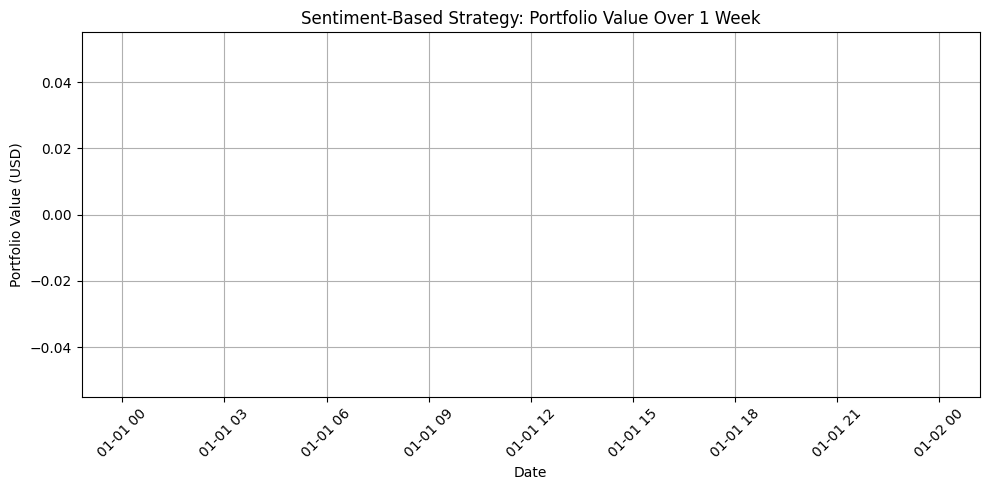

In [49]:
# Create DataFrame from strategy returns
df = pd.DataFrame(strategy_returns)

# Ensure correct data types
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df['portfolio_value'] = pd.to_numeric(df['portfolio_value'], errors='coerce')

# Plot the portfolio value
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['portfolio_value'], marker='o', linewidth=2)
plt.title('Sentiment-Based Strategy: Portfolio Value Over 1 Week')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()